In [1]:
import pandas as pd
import numpy as np
import nltk
import re
import csv
import seaborn as sns
from tqdm import tqdm
import matplotlib.pyplot as plt

In [2]:
data = []
with open("C:/Users/Jinkal/Desktop/main dataset/Dataset.txt", 'r') as f:
    reader = csv.reader(f, dialect='excel-tab')
    for row in tqdm(reader):
        data.append(row)

51it [00:00, 10228.54it/s]


In [3]:
book_name = []
Language = []
author = []
genre = []
abstract = []

for i in tqdm(data):
    book_name.append(i[0])
    genre.append(i[3])
    abstract.append(i[4])
    

books = pd.DataFrame({'book_name': book_name, 'genre': genre, 'abstract': abstract})
books.head(5)

books.shape

100%|███████████████████████████████████████████████████████████████████████████████| 51/51 [00:00<00:00, 35491.87it/s]


(51, 3)

In [4]:
books.drop(books[books['genre']==''].index, inplace=True)
books[books['genre']=='']

,book_name,genre,abstract


In [5]:
books['genre'].unique()

array(['Culture, Personal Development', 'Poetry',
       "Children's Literature, Literature, Fiction",
       'Literature, Personal Development', 'Fiction',
       "History, Children's Literature, Literature",
       'History, Personal Development', 'Arts, Culture, Literature',
       'Biography, Literature', '\xa0Crime, Mystery, Fiction',
       'Poetry, Literature', 'History, Politics, Literature',
       'History, Literature', 'Poetry, Literature, Fiction',
       'History, Literature, Fiction', 'History, Crime, Politics',
       'Literature, Personal Development, Fiction',
       'History, Culture, Literature', 'Literature, Fiction', 'Politics',
       'Sports, Literature', 'Personal Development',
       "Children's Literature, Literature", 'History, Fiction',
       'Crime, Fiction, Mystery', 'Fiction, Crime'], dtype=object)

In [6]:
genre = pd.DataFrame(books['genre'])

In [7]:
from collections import Counter
total_counts = Counter()
for i in range(len(genre)):
    for word in genre.values[i][0].split(', '):
        total_counts[word] += 1
print("Total words in data set: ", len(total_counts))

Total words in data set:  14


In [8]:
vocab = sorted(total_counts, key=total_counts.get, reverse=True)[:20000]
print(vocab[:60])

['Literature', 'Fiction', "Children's Literature", 'Poetry', 'History', 'Personal Development', 'Biography', 'Culture', 'Politics', 'Crime', 'Arts', 'Mystery', '\xa0Crime', 'Sports']


In [9]:
genres = nltk.FreqDist(total_counts)
genres_df = pd.DataFrame({'genre': list(genres.keys()), 'Count': list(genres.values())})

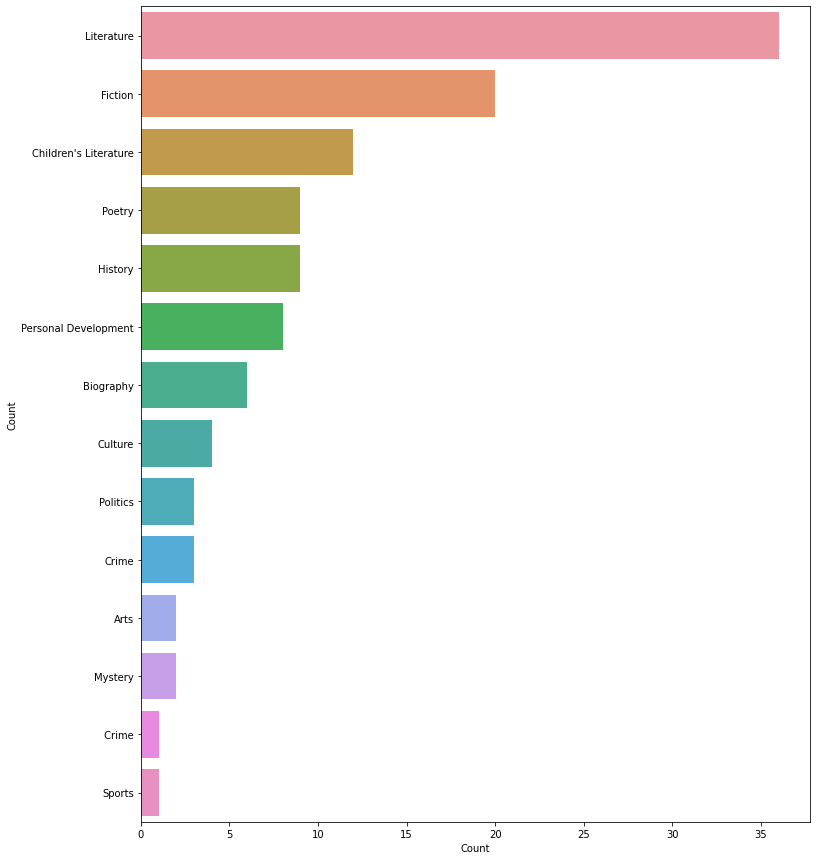

In [10]:
g = genres_df.nlargest(columns="Count", n = 50) 
plt.figure(figsize=(12,15))
ax = sns.barplot(data=g, x= "Count", y = "genre")
ax.set(ylabel = 'Count')
plt.show()

In [11]:
def clean_text(text):
    text = re.sub("\'", "", text)
    text = re.sub("[^a-zA-Z]"," ",text)
    text = ' '.join(text.split())
    text = text.lower()
    
    return text

In [12]:
books['clean_abstract'] = books['abstract'].apply(lambda x: clean_text(x))

In [13]:
books[['abstract', 'clean_abstract']].sample(3)

,abstract,clean_abstract
2,The raja loves jalebis. He even dreams of them...,the raja loves jalebis he even dreams of them ...
27,"In this way breaking study, Meena Radhakrishna...",in this way breaking study meena radhakrishna ...
39,Scriptural examinations and philosophy for qui...,scriptural examinations and philosophy for qui...


In [14]:
def freq_words(x, terms = 30):
  all_words = ' '.join([text for text in x])
  all_words = all_words.split()
  
  fdist = nltk.FreqDist(all_words)
  words_df = pd.DataFrame({'word':list(fdist.keys()), 'count':list(fdist.values())})
  
  d = words_df.nlargest(columns="count", n = terms) 
  plt.figure(figsize=(12,15))
  ax = sns.barplot(data=d, x= "count", y = "word")
  ax.set(ylabel = 'Word')
  plt.show()

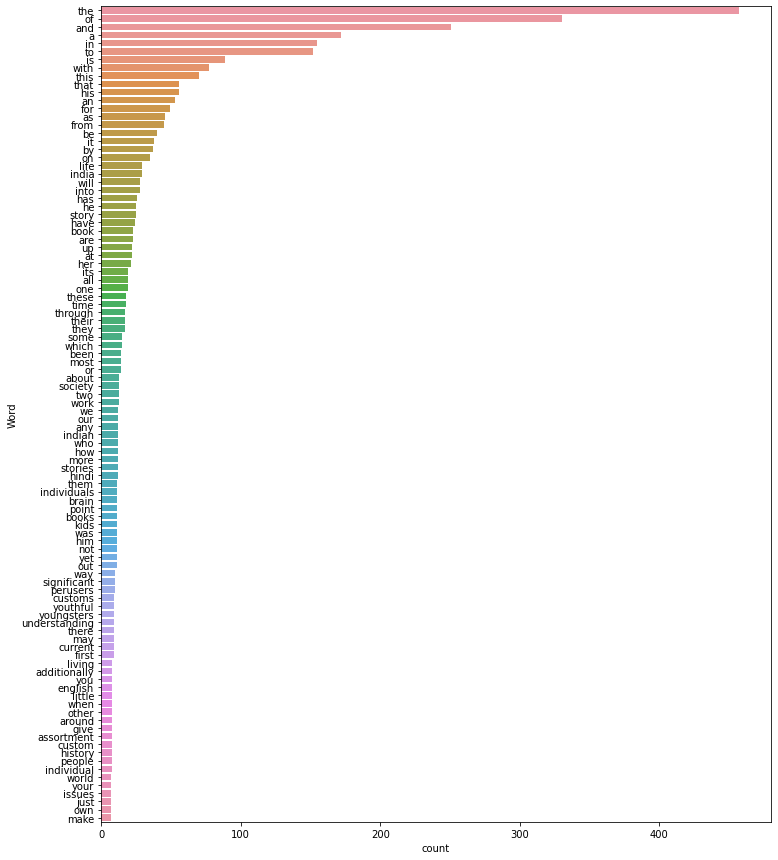

In [15]:
freq_words(books['clean_abstract'], 100)

In [16]:
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))

In [17]:
def remove_stopwords(text):
    no_stopword_text = [w for w in text.split() if not w in stop_words]
    return ' '.join(no_stopword_text)
  
books['clean_abstract'] = books['clean_abstract'].apply(lambda x: remove_stopwords(x))

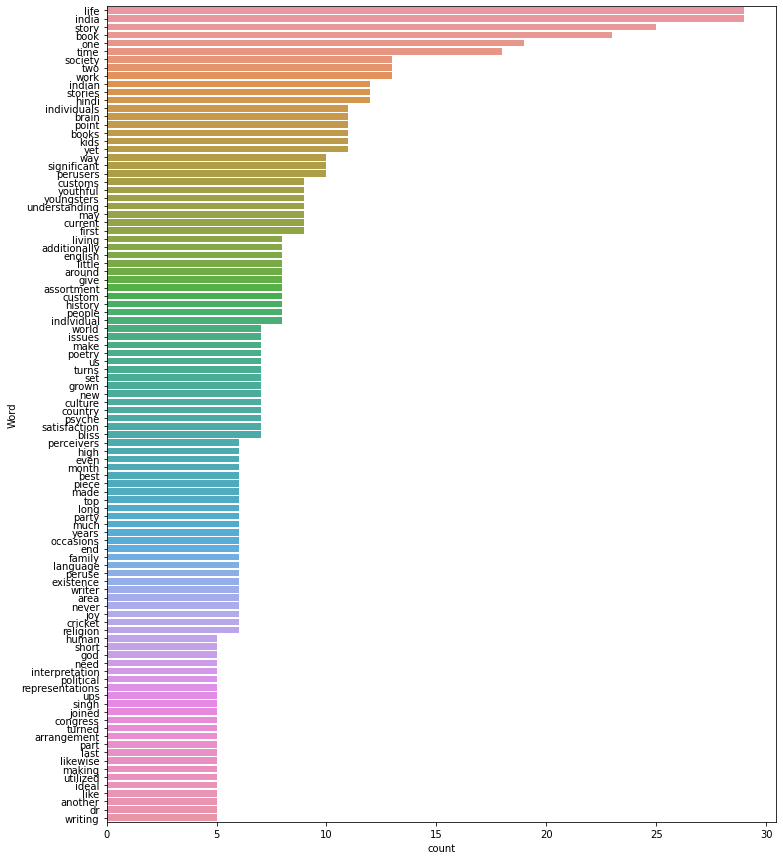

In [18]:
freq_words(books['clean_abstract'], 100)

In [19]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer(max_df=0.8, max_features=2000)

In [20]:
from sklearn.model_selection import train_test_split
xtrain, xval, ytrain, yval = train_test_split(books['clean_abstract'], books['genre'], test_size=0.2)

In [21]:
xtrain_tfidf = tfidf_vectorizer.fit_transform(xtrain)
xval_tfidf = tfidf_vectorizer.transform(xval)

In [22]:
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier

In [23]:
lr = LogisticRegression()
clf = OneVsRestClassifier(lr)

In [24]:
clf.fit(xtrain_tfidf, ytrain)

OneVsRestClassifier(estimator=LogisticRegression())

In [25]:
y_pred = clf.predict(xval_tfidf)

In [26]:
y_pred[9]

"Children's Literature, Literature, Fiction"

In [27]:
def infer_tags(q):
    q = clean_text(q)
    q = remove_stopwords(q)
    q_vec = tfidf_vectorizer.transform([q])
    q_pred = clf.predict(q_vec)
    return q_pred

In [28]:
for i in range(5):
    k = xval.sample(1).index[0]
    print("Books: ", books['book_name'][k], "\nPredicted genre: ", infer_tags(xval[k])), print("Actual genre:",books['genre'][k], "\n") 

Books:  Dosa 
Predicted genre:  ["Children's Literature, Literature, Fiction"]
Actual genre: Children's Literature, Literature, Fiction 

Books:  Says Kabir: A Collection of the Hundred and Ten Poems of Kabir 
Predicted genre:  ["Children's Literature, Literature, Fiction"]
Actual genre: Poetry, Literature 

Books:  Chandrakanta  
Predicted genre:  ["Children's Literature, Literature, Fiction"]
Actual genre: History, Literature, Fiction 

Books:  Chandrakanta  
Predicted genre:  ["Children's Literature, Literature, Fiction"]
Actual genre: History, Literature, Fiction 

Books:  Mother Teresa Symbol of Kindness 
Predicted genre:  ["Children's Literature, Literature, Fiction"]
Actual genre: Biography, Literature 



In [29]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

print(confusion_matrix(yval,y_pred))
print(classification_report(yval,y_pred))
print(accuracy_score(yval, y_pred))

[[0 1 0 0 0 0 0 0]
 [0 3 0 0 0 0 0 0]
 [0 1 0 0 0 0 0 0]
 [0 1 0 0 0 0 0 0]
 [0 1 0 0 0 0 0 0]
 [0 1 0 0 0 0 0 0]
 [0 1 0 0 0 0 0 0]
 [0 2 0 0 0 0 0 0]]
                                            precision    recall  f1-score   support

                     Biography, Literature       0.00      0.00      0.00         1
Children's Literature, Literature, Fiction       0.27      1.00      0.43         3
             Culture, Personal Development       0.00      0.00      0.00         1
                            Fiction, Crime       0.00      0.00      0.00         1
                          History, Fiction       0.00      0.00      0.00         1
              History, Literature, Fiction       0.00      0.00      0.00         1
                      Personal Development       0.00      0.00      0.00         1
                        Poetry, Literature       0.00      0.00      0.00         2

                                  accuracy                           0.27        11
     

c:\users\jinkal\appdata\local\programs\python\python38\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\jinkal\appdata\local\programs\python\python38\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\jinkal\appdata\local\programs\python\python38\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,